In [56]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [11]:
data = []
train_dir = r"training_set/training_set"

for filename in os.listdir(train_dir):
    if filename.endswith(".png") and not filename.endswith("_Annotation.png"):
        img_path = os.path.join(train_dir, filename)
        annotation_path = img_path.replace(".png", "_Annotation.png")

        if os.path.exists(annotation_path):
            data.append({"img_path": img_path, "annotation_path": annotation_path})

In [13]:
len(data)

999

In [14]:
data[0]

{'img_path': 'training_set/training_set\\100_2HC.png',
 'annotation_path': 'training_set/training_set\\100_2HC_Annotation.png'}

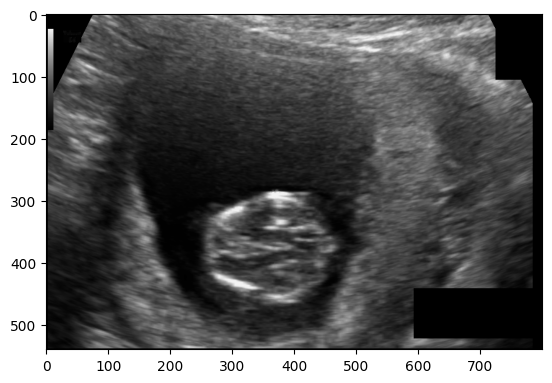

In [21]:
test = cv2.imread(data[0]["img_path"])
plt.imshow(test)

In [28]:
train_data = pd.DataFrame(data)
train_data.head()

,img_path,annotation_path
0,training_set/training_set\100_2HC.png,training_set/training_set\100_2HC_Annotation.png
1,training_set/training_set\101_HC.png,training_set/training_set\101_HC_Annotation.png
2,training_set/training_set\102_2HC.png,training_set/training_set\102_2HC_Annotation.png
3,training_set/training_set\103_HC.png,training_set/training_set\103_HC_Annotation.png
4,training_set/training_set\104_HC.png,training_set/training_set\104_HC_Annotation.png


In [29]:
test.shape # RGB

(540, 800, 3)

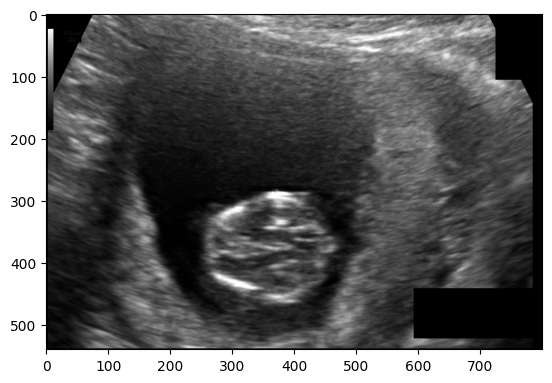

In [33]:
test = train_data.iloc[0]["img_path"]
img = cv2.imread(test, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

In [34]:
img.shape

(540, 800)

### Denoising Images using NLM

In [35]:
denoised_img = cv2.fastNlMeansDenoising(img, h=10, templateWindowSize=7, searchWindowSize=21)

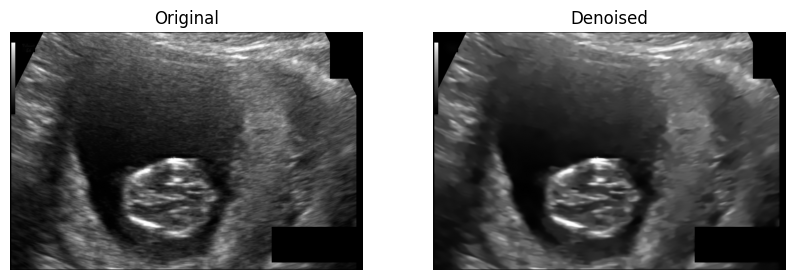

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(denoised_img, cmap="gray")
ax[1].set_title("Denoised")
ax[1].axis("off")

plt.show()

In [37]:
def denoise_img(img_path):
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    denoised_img = cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)
    return denoised_img

In [43]:
tqdm.pandas(desc="Denoising Images")
train_data["denoised_img"] = train_data["img_path"].progress_apply(denoise_img)

Denoising Images:   0%|          | 0/999 [00:00<?, ?it/s]

Denoising Images: 100%|██████████| 999/999 [07:34<00:00,  2.20it/s]


In [45]:
print(train_data["denoised_img"].iloc[0].shape)

(540, 800)


### Computing SSIM to evaluate noise reduction

In [48]:
def compute_ssim(img_path, denoised_img):
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    return ssim(gray, denoised_img)

In [47]:
ssim_scores = []
for _, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Computing SSIM"):
    ssim_score = compute_ssim(row["img_path"], row["denoised_img"])
    ssim_scores.append(ssim_score)

avg_ssim = np.mean(ssim_scores)
print(f"Average SSIM: {avg_ssim}")

Computing SSIM: 100%|██████████| 999/999 [01:19<00:00, 12.64it/s]

Average SSIM: 0.9441810728585027


> .94 SSIM --> excellent noise reduction while not losing structural information in the imags

### Apply CLAHE for contrast enhancement

In [50]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
    return clahe.apply(img) 

In [51]:
tqdm.pandas(desc="Applying CLAHE")
train_data["clahe_img"] = train_data["denoised_img"].progress_apply(apply_clahe)

Applying CLAHE: 100%|██████████| 999/999 [00:00<00:00, 1270.74it/s]


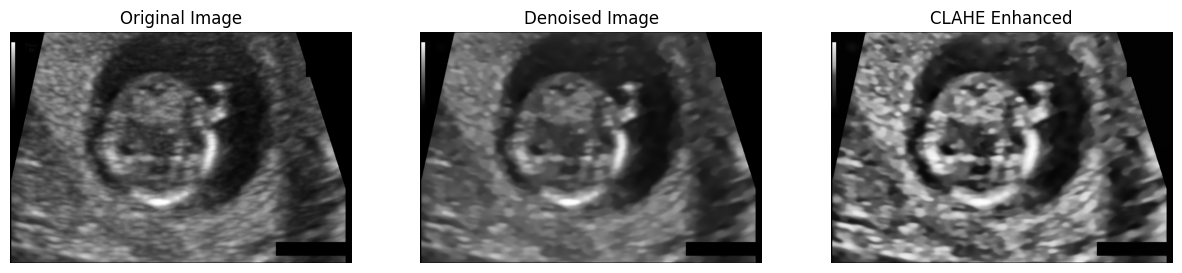

In [52]:
sample_idx = 21 
original_img = cv2.imread(train_data.iloc[sample_idx]["img_path"], cv2.IMREAD_GRAYSCALE)
denoised_img = train_data.iloc[sample_idx]["denoised_img"]
clahe_img = train_data.iloc[sample_idx]["clahe_img"]

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(original_img, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(denoised_img, cmap="gray")
ax[1].set_title("Denoised Image")
ax[1].axis("off")

ax[2].imshow(clahe_img, cmap="gray")
ax[2].set_title("CLAHE Enhanced")
ax[2].axis("off")

plt.show()


### Computing Entropy to ensure CLAHE enhancement is effective or not

In [57]:
def compute_entropy(img):
    return np.mean(entropy(img, disk(5)))

In [58]:
org_entropy = [compute_entropy(cv2.imread(row["img_path"], cv2.IMREAD_GRAYSCALE)) for _, row in train_data.iterrows()]
denoised_entropy = [compute_entropy(row["denoised_img"]) for _, row in train_data.iterrows()]
clahe_entropy = [compute_entropy(row["clahe_img"]) for _, row in train_data.iterrows()]

print("Average Entropy Scores..")
print(f"Original Images: {np.mean(org_entropy):.4f}")
print(f"Denoised Images: {np.mean(denoised_entropy):.4f}")
print(f"CLAHE Images: {np.mean(clahe_entropy):.4f}")

Average Entropy Scores..
Original Images: 2.9726
Denoised Images: 2.5147
CLAHE Images: 2.9170


> Interpretation
1. Denoising reduced entropy --> Expected behavior since noise contributes to randomness.
2. CLAHE restored entropy close to original --> Suggests it is enhancing details without excessive noise boost.
3. Entropy didn't exceed original image --> CLAHE isn't over-enhancing noise, which is good.

### Applying Adaptive Thresholding and finding Circular Contours

In [69]:
def adaptive_threshold(img):
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

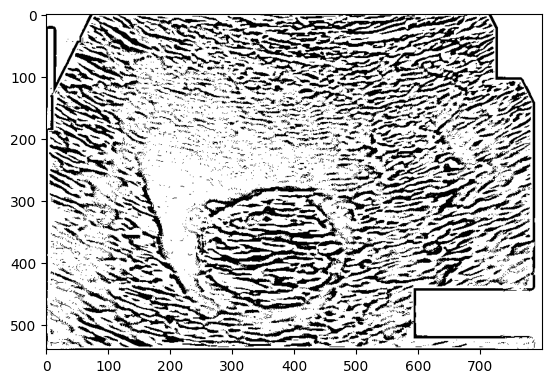

In [75]:
img = train_data.iloc[0]["clahe_img"]
thresh = adaptive_threshold(img)
plt.imshow(thresh, cmap="gray")

In [76]:
train_data.to_csv("train_data.csv")